# DPO

## Setup

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import re
import random
import string
import nltk
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
# For tokenization and dataset loading
from transformers import AutoTokenizer
from datasets import load_dataset

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [2]:
torch.manual_seed(42)

### Initializing device here for future use if needed

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from dataclasses import dataclass

@dataclass
class smolConfig:
    vocab_size = 49152
    hidden_size = 576
    intermediate_size = 1536
    num_hidden_layers = 30
    num_heads = 9
    kv_heads = 3

In [5]:
def rotate_half(x):
    """
    Helper function to rotate the left half of a tensor along its final dimension.
    """
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]

    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """
    Applies RoPE on the query and key tensors.
    """
    cos, sin = cos.to(q.device), sin.to(q.device)

    # Unsqueexzing to enable broadcasting
    sin = sin.unsqueeze(unsqueeze_dim)
    cos = cos.unsqueeze(unsqueeze_dim)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)

    return q_embed, k_embed

class RotaryEmbedder(nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        # Precompute frequency for sine/cosine embeddings
        self.freq = 1.0 / (base ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))

    @torch.no_grad()
    def forward(self, x):
        # Generate positions (sequence indices) for the input
        pos = torch.arange(x.shape[-2], dtype=torch.long)
        # Compute angles for sine and cosine embeddings
        angles = torch.einsum("p,f->pf", pos.float(), self.freq).unsqueeze(dim=0)
        # Duplicate angles for sine and cosine embeddings
        emb = torch.cat((angles, angles), dim=-1)
        # Return cosine and sine components of the positional embeddings
        return emb.cos(), emb.sin()

class GroupedQueryAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Model dimensions and attention configurations
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = config.hidden_size // self.num_heads
        self.kv_heads = config.kv_heads  # Number of key-value heads
        self.rope_theta = 10000.0  # Scaling factor for rotary embeddings

        # Linear projections for queries, keys, values, and output
        self.q_proj = nn.Linear(config.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(config.hidden_size, self.kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(config.hidden_size, config.hidden_size, bias=False)

        # Rotary embedding generator
        self.rotary_emb = RotaryEmbedder(base=self.rope_theta, dim=self.head_dim)

    def _repeat_kv(self, x, n_rep):
        batch, num_key_value_heads, slen, head_dim = x.shape
        # Expand the number of key-value heads by repeating them
        x = x[:, :, None, :, :].expand(
            batch, num_key_value_heads, n_rep, slen, head_dim
        )
        # Reshape to align with the expected multi-head attention format
        return x.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

    def forward(self, x: torch.Tensor, attention_mask=None):
        # Input dimensions: (batch_size, seq_len, hidden_size)
        b, q, _ = x.size()

        # Project input hidden states into queries, keys, and values
        q_states = self.q_proj(x)
        k_states = self.k_proj(x)
        v_states = self.v_proj(x)

        # Reshape and transpose for multi-head attention
        q_states = q_states.view(b, q, self.num_heads, self.head_dim).transpose(1, 2)
        k_states = k_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)
        v_states = v_states.view(b, q, self.kv_heads, self.head_dim).transpose(1, 2)

        # Compute rotary positional embeddings
        cos, sin = self.rotary_emb(q_states)
        cos = cos.to(q_states.device)
        sin = sin.to(q_states.device)
        # Apply positional embeddings to queries and keys
        q_states, k_states = apply_rotary_pos_emb(q_states, k_states, cos, sin)

        # Repeat key and value tensors to match the number of query heads
        __kv_groups = self.num_heads // self.kv_heads
        k_states = self._repeat_kv(k_states, __kv_groups)
        v_states = self._repeat_kv(v_states, __kv_groups)

        # Compute attention scores (scaled dot-product attention)
        attn_weights = torch.matmul(q_states, k_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        # Add attention mask (e.g., for causal or padding masking)
        attn_weights = attn_weights + attention_mask

        # Normalize attention weights using softmax
        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        # Apply dropout to attention weights
        attn_weights = nn.functional.dropout(attn_weights, 0)

        # Compute attention output
        attn_output = torch.matmul(attn_weights, v_states)
        # Reshape and transpose back to original format
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.reshape(b, q, -1)

        # Project the attention output back to the hidden size
        attn_output = self.o_proj(attn_output)

        # Return the final attention output
        return attn_output

In [6]:
torch.manual_seed(42)

class RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        """
        This is the Root Mean Square Normalisation class.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))  # Learnable scaling factor
        self.variance_epsilon = eps

    def forward(self, x):
        # Calculate variance along the last dimension (hidden size)
        variance = x.pow(2).mean(-1, keepdim=True)

        # Normalize and scale
        x = x * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * x

class MLP(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        """
        This is the gated MLP from the LLaMa architecture. Here we use the SiLU acitvation.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.activation = nn.modules.activation.SiLU()

        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)

    def forward(self, x):
        down_proj = self.down_proj(self.activation(self.gate_proj(x)) * self.up_proj(x))
        return down_proj

class LlamaDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        """
        This is the Llama decoder block.
        """
        # Self Attention Module
        self.self_attn = GroupedQueryAttention(config)

        # FFN Module
        self.mlp = MLP(hidden_size=config.hidden_size, intermediate_size=config.intermediate_size)

        # Pre Attention and Post Attention normalisation
        self.input_layernorm = RMSNorm(config.hidden_size, eps=1e-05)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, x, attention_mask):
        # Skip connection cache

        residual = x

        # Pre-attention normalisation
        x = self.input_layernorm(x)

        # A causal attention mask (i.e., decoder can only look at tokens that it has generated thus far)
        attention_mask = torch.triu(torch.full((attention_mask.shape[-1], attention_mask.shape[-1]),
                                               fill_value=float('-inf')), diagonal=1)

        attention_mask = attention_mask.to(x.device)

        # Self-attention block
        x = self.self_attn(x=x,attention_mask=attention_mask)
        x += residual

        # Skip connection cache for MLP
        residual = x

        # Pre-MLP normalisation
        x = self.post_attention_layernorm(x)

        # MLP block
        x = self.mlp(x)
        x += residual

        return x

In [7]:
torch.manual_seed(42)

class smolModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # embedding layer which maps each token to a vector embedding
        self.embed_tokens = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.hidden_size
        )

        # Stack of decoder layers (LlamaDecoder) defined by the configuration
        self.layers = nn.ModuleList([
            LlamaDecoder(config) for _ in range(config.num_hidden_layers)
        ])

        # RMSNorm: final layer normalization applied to hidden states
        self.norm = RMSNorm(config.hidden_size, eps=1e-05)

    def forward(self, input_ids=None, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        x = inputs_embeds

        # Pass embeddings through each decoder layer
        for i, decoder_layer in enumerate(self.layers):
            layer_outputs = decoder_layer(
                x,
                attention_mask=attention_mask
            )
            x = layer_outputs

        # Final normalisation
        x = self.norm(x)

        return x

class smolLM(nn.Module):
    """
    This is the Language Model.
    It passes the embeddings from the SmolLM backbone into a LM head.
    The LM head generates logits over the space of the entire vocabulary for next word prediction.
    """
    def __init__(self, config):
        super().__init__()
        # SmolLM backbone which generates the contextualised embeddings for the input tokens
        self.model = smolModel(config)
        # The LM head which maps embeddings to logits over the vocabulary
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        # weights between LM head and the token_embedding layer are shared in the SmolLM architecture
        self.tie_weights()

    def tie_weights(self):
        # lm_head shares weights with the embedding layer
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(self, input_ids, attention_mask):
        # Input tokens are passed to the SmolLM backbone
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        # embeddings corresponding to each input token => (batch_size, seq_len, emb_dim)
        x = outputs

        # pass the embeddings through the LM head
        logits = self.lm_head(x).float()
        return {'logits': logits}

In [8]:
def __generate(model, inputs, num_tokens, tokenizer, max_length=50):
    """
    A basic greedy approach for text generation.
    """
    collect = []
    for _ in range(num_tokens):
        output = model(**inputs)
        output_id = torch.argmax(output['logits'][0, -1]).item()
        collect.append(output_id)
        if output_id == tokenizer.eos_token_id or len(collect) >= max_length:
            break
        # Update input_ids and attention_mask
        new_token = torch.tensor([output_id], device=inputs['input_ids'].device)
        inputs['input_ids'] = torch.cat([inputs['input_ids'][0], new_token]).unsqueeze(0)
        inputs['attention_mask'] = F.pad(inputs['attention_mask'], (0, 1), value=1)
    return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(collect))

## Preference Optimization

#### Loading Models

We need to load a policy model and a reference model. Both models will be initiliazed from the finetuned model weights. We need to freeze the reference model so that it does not get updated during training. The policy model will be updated using DPO.

In [ ]:
# Load model config
config = smolConfig()
path = '/kaggle/input/fully_fine_tuned_model/pytorch/default/1/full_finetuned_smolLM.pth'

# TODO: Initiliaze the policy model and load the weights
policy_model = smolLM(config)
state_dict = torch.load(path, map_location=device)
policy_model.load_state_dict(state_dict)

# TODO: Initialize the reference model and load the weights
reference_model = smolLM(config)
reference_model.load_state_dict(state_dict)
reference_model.eval()

# TODO: Freeze all parameters in the reference model
for param in reference_model.parameters():
    param.requires_grad = False

# Move the models to the appropriate device (GPU or CPU)
policy_model.to(device)
reference_model.to(device)

smolLM(
  (model): smolModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoder(
        (self_attn): GroupedQueryAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): RotaryEmbedder()
        )
        (mlp): MLP(
          (activation): SiLU()
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (lm_head): Linear(in_features=576, out_features=49152, bias=

Next, we will need to freeze part of the policy model to make training feasible on your devices. You just need to run the code in this section. Before you ask on slack, you are allowed to change the number of layers to freeze to reduce training time, debug or for any other reason. You can also comment out the code block entirely should you wish to train the entire model. However, you will be graded on whether your preference accuracy increases at the end, so keep that in mind.

In [10]:
layers_to_freeze = 25

for name, param in policy_model.named_parameters():
    if name.startswith("model.embed_tokens"):
        param.requires_grad = False
    elif name.startswith("model.norm"):
        param.requires_grad = False
    elif name.startswith("lm_head"):
        param.requires_grad = True
    elif name.startswith("model.layers."):
        layer_num = int(name.split(".")[2])
        if layer_num < layers_to_freeze:
            param.requires_grad = False
        else:
            param.requires_grad = True
    else:
        param.requires_grad = True

Checking number of trainable parameters.

In [11]:
trainable_params = sum(p.numel()
                       for p in policy_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in policy_model.parameters())
print(
    f"Trainable params: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

Trainable params: 17,700,480 / 134,515,008 (13.16%)


#### Loading and Processing Dataset

We load in the dataset and tokenizer and modify the dataset to fit our needs.

In [12]:
# Load dataset
dpo_dataset = load_dataset("Dahoas/full-hh-rlhf")

# Use only a small subset for fast training
data = dpo_dataset["train"].shuffle(seed=42)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")

# The tokenizer does not have a defined padding token, so we initialize our own as the EoS token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

README.md:   0%|          | 0.00/478 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/930 [00:00<?, ?B/s]

(…)-00000-of-00001-8349d0765e6718df.parquet:   0%|          | 0.00/123M [00:00<?, ?B/s]

(…)-00000-of-00001-ec71e9262143a91c.parquet:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/112052 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12451 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

To stabilize our training, we want to eliminate examples that may be redundant. Since we don't have preference scores in this dataset, you must think of a way to shortlist useful datapoints yourself. You can do this by analyzing the length of responses, looking for common phrases that may indicate weak choices, etc. You may also use a reward model, but that may prove to be too much work.

In [ ]:
# TODO: Define the function
def is_strong_preference(example):
    """
    Function to filter out weak preferences from the dataset.

    Arguments:
        example: A dictionary containing the prompt, chosen, and rejected completions.

    Returns:
        bool: True if the example is a strong preference, False otherwise.
    """
    stop_words = set(stopwords.words('english'))
    chosen = example.get("chosen", "").strip()
    rejected = example.get("rejected", "").strip()

    if len(chosen) < 60 or len(rejected) < 60:
        return False
    if abs(len(chosen) - len(rejected)) < 40:
        return False

    chosen_tokens = word_tokenize(chosen.lower())
    rejected_tokens = word_tokenize(rejected.lower())
    chosen_stop_count = 0
    for word in chosen_tokens:
        if word in stop_words:
            chosen_stop_count += 1

    rejected_stop_count = 0
    for word in rejected_tokens:
        if word in stop_words:
            rejected_stop_count += 1

    chosen_ratio = chosen_stop_count / (len(chosen_tokens) + 3e-8)
    rejected_ratio = rejected_stop_count / (len(rejected_tokens) + 3e-8)
    if chosen_ratio > 0.6 or rejected_ratio > 0.6:
        return False

    chosen_tags = pos_tag(chosen_tokens)
    rejected_tags = pos_tag(rejected_tokens)
    chosen_nv_count = 0
    for word, tag in chosen_tags:
        if tag.startswith("NN") or tag.startswith("VB"):
            chosen_nv_count += 1

    rejected_nv_count = 0
    for word, tag in rejected_tags:
        if tag.startswith("NN") or tag.startswith("VB"):
            rejected_nv_count += 1

    if chosen_nv_count <= rejected_nv_count:
        return False
    weak_phrases = ["i don't know", "not sure", "maybe","as an ai language model", "hope this helps","i'm sorry", "i cannot", "i apologize"]
    chosen_lower = chosen.lower()
    rejected_lower = rejected.lower()
    for phrase in weak_phrases:
        if phrase in chosen_lower or phrase in rejected_lower:
            return False
    return True


strong_data = data.filter(is_strong_preference)

print(
    f"Filtered down to {len(strong_data)} / {len(data)} strong examples")


Filter:   0%|          | 0/112052 [00:00<?, ? examples/s]

Filtered down to 34460 / 112052 strong examples


In [14]:
# NOTE: you can reduce the size for debugging but you should use all 1000 for the final submission
split_size = 1000

split = strong_data.select(range(split_size)).train_test_split(test_size=0.1, seed=42)
train_data = split["train"]
test_data = split["test"]

Yes, you are allowed to change the batch size.

In [15]:
class DPODataset(torch.utils.data.Dataset):
    def __init__(self, raw_data):
        self.data = raw_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "prompt": item["prompt"],
            "chosen": item["chosen"],
            "rejected": item["rejected"]
        }

train_loader = DataLoader(DPODataset(train_data), batch_size=8, shuffle=True)
test_loader = DataLoader(DPODataset(test_data), batch_size=8)

In [16]:
# TODO: Define the function
def tokenize_pairs(prompts, responses):
    """
    Tokenizes pairs of prompts and responses using the tokenizer.
    """
    token_output = tokenizer(prompts,responses,padding=True,truncation=True,max_length=512,return_tensors="pt")
    return token_output

#### Loss Function 

In [ ]:
# TODO: Define the function
def compute_logprob(model, input_ids, attention_mask):
    """
    Computes the average log-probability per sample in a batch for causal language modeling.

    Args:
        model: A language model that outputs logits for next-token prediction.
        input_ids (Tensor): Tensor of shape (batch_size, seq_len) containing token IDs.
        attention_mask (Tensor): Tensor of shape (batch_size, seq_len) indicating non-padding tokens.

    Returns:
        Tensor of shape (batch_size,) containing average log-probabilities for each sample.
    """
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    lt = outputs["logits"]

    lt = lt[:, slice(0, -1), :]
    logpx = F.log_softmax(lt, dim=-1)

    target_ids = input_ids[:, slice(1, input_ids.size(1))]
    mask = attention_mask[:, 1:]
    mask = mask.to(torch.float)

    B, Tm1, V = logpx.shape
    batch_idx = torch.arange(B, device=logpx.device).unsqueeze(1).expand(B, Tm1)
    time_idx  = torch.arange(Tm1, device=logpx.device).unsqueeze(0).expand(B, Tm1)
    token_probs = logpx[batch_idx, time_idx, target_ids]

    mtokens = token_probs * mask
    sum_logpob = mtokens.sum(dim=1)
    lengths = mask.sum(dim=1).clamp(min=1)
    return sum_logpob / lengths


# TODO: Define the function
def dpo_loss(policy_model, ref_model, chosen_inputs, rejected_inputs, beta=0.1):
    """
    Computes the Direct Preference Optimization (DPO) loss for a batch.

    Args:
        policy_model: The trainable language model to align with human preferences.
        ref_model: The frozen reference model (typically the SFT baseline).
        chosen_inputs (dict): Tokenized inputs of (prompt + chosen response).
        rejected_inputs (dict): Tokenized inputs of (prompt + rejected response).
        beta (float): Scaling factor for the preference margin (contrast strength).

    Returns:
        A tuple of:
            - Scalar loss averaged over the batch
            - Logits difference vector (useful for accuracy or debugging)
    """
    cpol = compute_logprob(policy_model, **chosen_inputs)
    lpol = compute_logprob(policy_model, **rejected_inputs)
    pol_delta = cpol - lpol

    lp_c_ref = compute_logprob(ref_model, **chosen_inputs)
    lp_r_ref = compute_logprob(ref_model, **rejected_inputs)
    ref_delta = lp_c_ref - lp_r_ref

    raw_diff = pol_delta - ref_delta
    logits_difference = raw_diff * beta
    loss = torch.log1p(torch.exp(-logits_difference)).mean() #log1p does ln(1 + x)
    return loss, logits_difference

#### Training

In [ ]:
# Set models to appropriate mode
policy_model.train()
reference_model.eval()

# Optimizer (you can change the lr and/or optimizer if you wish)
optimizer = torch.optim.AdamW(policy_model.parameters(), lr=1e-4)

# Initialize stats
all_losses = []
all_logits_diff = []
running_loss = 0.0

# TODO: Write the training loop
for step, batch in enumerate(tqdm(train_loader, desc="Training")):
    tok_chosen   = tokenize_pairs(batch["prompt"], batch["chosen"])
    for k, v in tok_chosen.items():
        tok_chosen[k] = v.to(device)

    tok_rejected = tokenize_pairs(batch["prompt"], batch["rejected"])
    for k, v in tok_rejected.items():
        tok_rejected[k] = v.to(device)

    optimizer.zero_grad()
    loss, logits_diff = dpo_loss(policy_model, reference_model,chosen_inputs=tok_chosen,rejected_inputs=tok_rejected,beta=0.1)
    loss.backward()
    optimizer.step()
    batch_loss = loss.item()
    avg_logit_diff = logits_diff.mean().item()
    running_loss += batch_loss
    all_losses.append(batch_loss)
    all_logits_diff.append(avg_logit_diff)

    print(f"Step {step} Batch Loss: {batch_loss:.4f} Logits Diff: {avg_logit_diff:.4f} Running Loss: {running_loss/(step+1):.4f}")


Step 0 Batch Loss: 0.6931 Logits Diff: 0.0000 Running Loss: 0.6931
Step 1 Batch Loss: 0.6805 Logits Diff: 0.0257 Running Loss: 0.6868
Step 2 Batch Loss: 0.6716 Logits Diff: 0.0439 Running Loss: 0.6818
Step 3 Batch Loss: 0.6639 Logits Diff: 0.0614 Running Loss: 0.6773
Step 4 Batch Loss: 0.6539 Logits Diff: 0.0829 Running Loss: 0.6726
Step 5 Batch Loss: 0.6267 Logits Diff: 0.1440 Running Loss: 0.6650
Step 6 Batch Loss: 0.6583 Logits Diff: 0.0730 Running Loss: 0.6640
Step 7 Batch Loss: 0.6264 Logits Diff: 0.1557 Running Loss: 0.6593
Step 8 Batch Loss: 0.6066 Logits Diff: 0.1957 Running Loss: 0.6535
Step 9 Batch Loss: 0.6216 Logits Diff: 0.1698 Running Loss: 0.6503
Step 10 Batch Loss: 0.5571 Logits Diff: 0.3355 Running Loss: 0.6418
Step 11 Batch Loss: 0.6340 Logits Diff: 0.1536 Running Loss: 0.6411
Step 12 Batch Loss: 0.5604 Logits Diff: 0.3303 Running Loss: 0.6349
Step 13 Batch Loss: 0.6188 Logits Diff: 0.1994 Running Loss: 0.6338
Step 14 Batch Loss: 0.5363 Logits Diff: 0.4884 Running Los

Plot the loss curve

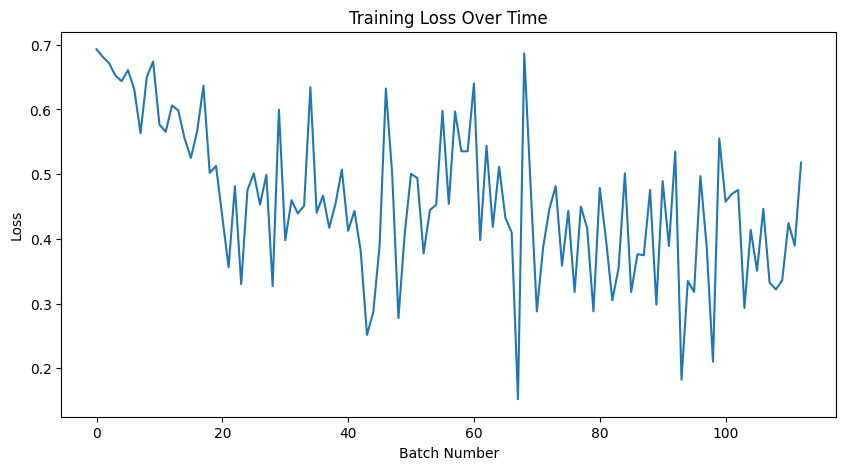

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

Plot the logits difference

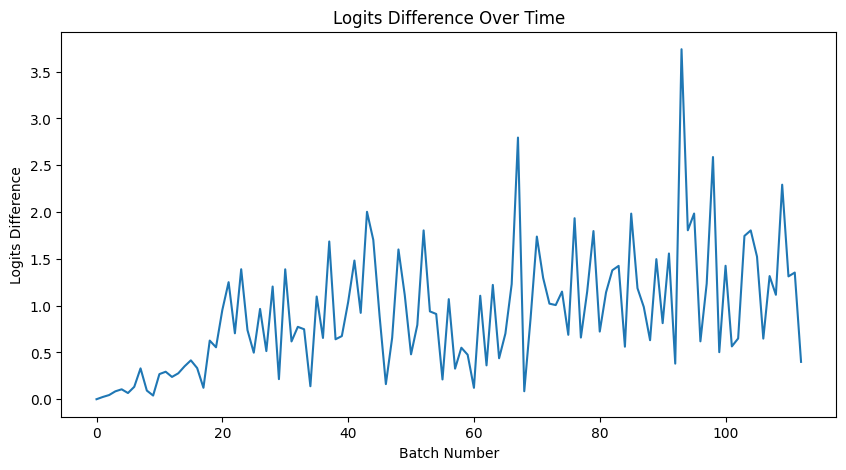

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(all_logits_diff, label='Logits Difference')
plt.xlabel('Batch Number')
plt.ylabel('Logits Difference')
plt.title('Logits Difference Over Time')
plt.show()

#### Evaluation

Evaluating the model to see the fruits of our labour.

In [21]:
# TODO: Define the function
def compute_accuracy(logits_diff):
    """
    Computes accuracy: how often the model prefers the chosen response (logits_diff > 0)

    Args:
        logits_diff (Tensor): Vector of logits differences for a batch

    Returns:
        accuracy (float): Accuracy as a decimal (between 0 and 1)
    """
    return (logits_diff > 0).float().mean().item()

In [22]:
# TODO: Define the function
def evaluate_dpo_accuracy(model, loader, beta=0.1):
    """
    Evaluates how often the model prefers the chosen response over the rejected one.
    Returns: accuracy as a float (0 to 1)
    """
    model.eval()
    all_logits_diff = []

    with torch.no_grad():
        for batch in loader:
            chosen_inputs   = tokenize_pairs(batch["prompt"], batch["chosen"])
            rejected_inputs = tokenize_pairs(batch["prompt"], batch["rejected"])
            for key in chosen_inputs:
                chosen_inputs[key]   = chosen_inputs[key].to(device)
                rejected_inputs[key] = rejected_inputs[key].to(device)

            logp_chosen   = compute_logprob(model, **chosen_inputs)
            logp_rejected = compute_logprob(model, **rejected_inputs)

            logits_diff = (logp_chosen - logp_rejected) * beta
            all_logits_diff.append(logits_diff)

    all_logits_diff = torch.cat(all_logits_diff)
    return compute_accuracy(all_logits_diff)


ref_acc = evaluate_dpo_accuracy(reference_model, test_loader)
policy_acc = evaluate_dpo_accuracy(policy_model, test_loader)

print(f"Reference Model Accuracy: {ref_acc * 100:.2f}%")
print(f"Policy Model Accuracy:    {policy_acc * 100:.2f}%")

Reference Model Accuracy: 72.00%
Policy Model Accuracy:    93.00%


Next, you must write code to show a few comparisons between the reference (baseline) and the policy model. Randomly sample 3 prompts from the test set and generate responses from both models.

In [ ]:
# TODO: Display sample inputs and outputs from each model
MAX_LEN = 512
NUM_TOKENS = 50
reference_model.eval()
policy_model.eval()
indices = random.sample(range(len(test_data)), 3)

for i, idx in enumerate(indices, start=1):
    ex = test_data[idx]
    prompt = ex["prompt"].strip()

    print("\n" + "="*60)
    print(f" Sample {i} ".center(60, "="))
    print("="*60 + "\n")
    print("Prompt:")
    print(prompt + "\n")

    toks = tokenizer(prompt,return_tensors="pt",truncation=True,max_length=MAX_LEN,padding=True).to(device)
    ref_inputs = {"input_ids": toks["input_ids"].clone(),"attention_mask": toks["attention_mask"].clone()}
    ref_response = __generate(reference_model, ref_inputs, NUM_TOKENS, tokenizer).strip()
    pol_inputs = {"input_ids": toks["input_ids"].clone(),"attention_mask": toks["attention_mask"].clone()}
    policy_response = __generate(policy_model, pol_inputs, NUM_TOKENS, tokenizer).strip()

    print("Reference model response:")
    print(ref_response + "\n")
    print("Policy model response:")
    print(policy_response + "\n")



========================= Sample 1 =========================

Prompt:
Human: What states were a part of the original 13 colonies?

Assistant: The original thirteen colonies in the American colonies were Virginia, North Carolina, South Carolina, Georgia, New Hampshire, Massachusetts Bay, Rhode Island, Connecticut, Pennsylvania, New York, New Jersey, Delaware, and Maryland.

Human: What states joined shortly after the original 13?

Assistant: Within the first two decades after the original American colonies established independence from Great Britain, the following states joined the Union: Vermont, New Hampshire, Kentucky, Tennessee, Ohio, Indiana, Louisiana, Mississippi, Alabama, Maine, Missouri, Arkansas, and Florida.

Human: What about California? What year did it become a state?

Assistant: California became the 31st state of the union in 1850.

Human: Thanks for helping me to learn a little bit more about the history of the states.

Assistant:

Reference model response:
Have a grea